In [1]:
# Cell 1: required libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model, datasets, optimizers, losses, metrics


In [2]:
# Cell 2: load and preprocess
(x_train_all, y_train_all), (x_test_all, y_test_all) = datasets.mnist.load_data()

# normalize to [0,1] and add channel dimension for conv nets
x_train_all = (x_train_all.astype("float32") / 255.0)[..., None]  # shape: (N,28,28,1)
x_test_all  = (x_test_all.astype("float32")  / 255.0)[..., None]

# For anomaly detection: use one digit as "normal" class, e.g., digit 1
normal_class = 1
x_train = x_train_all[y_train_all == normal_class]  # train only on normal samples
x_test  = x_test_all
y_test  = y_test_all

print("Train shape (normal only):", x_train.shape)
print("Test shape (full):", x_test.shape)


Train shape (normal only): (6742, 28, 28, 1)
Test shape (full): (10000, 28, 28, 1)


In [3]:
# Cell 3: convolutional autoencoder (small, effective for MNIST)

input_shape = (28, 28, 1)
latent_dim = 16

# Encoder
inp = layers.Input(shape=input_shape)
x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inp)  # 14x14x32
x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)    # 7x7x64
x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, name="latent")(x)
encoder = Model(inp, latent, name="encoder")

# Decoder
latent_in = layers.Input(shape=(latent_dim,))
x = layers.Dense(7*7*64, activation='relu')(latent_in)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # 14x14x64
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)  # 28x28x32
decoded = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)             # 28x28x1
decoder = Model(latent_in, decoded, name="decoder")

# Autoencoder
ae_in = layers.Input(shape=input_shape)
ae_latent = encoder(ae_in)
ae_out = decoder(ae_latent)
autoencoder = Model(ae_in, ae_out, name="autoencoder")


In [4]:
# Cell 4: compile
# Use binary_crossentropy or MSE; binary_crossentropy often works well for [0,1] pixels.
autoencoder.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.BinaryCrossentropy(),
    metrics=[metrics.MeanSquaredError()]
)


In [5]:
# Cell 5: train (train only on normal class examples)
history = autoencoder.fit(
    x_train, x_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.3443 - mean_squared_error: 0.1007 - val_loss: 0.1360 - val_mean_squared_error: 0.0325
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1328 - mean_squared_error: 0.0314 - val_loss: 0.1191 - val_mean_squared_error: 0.0270
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1099 - mean_squared_error: 0.0240 - val_loss: 0.0799 - val_mean_squared_error: 0.0138
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0778 - mean_squared_error: 0.0131 - val_loss: 0.0727 - val_mean_squared_error: 0.0120
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0673 - mean_squared_error: 0.0101 - val_loss: 0.0591 - val_mean_squared_error: 0.0075
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0565 - mean_squared_error: 0.0066 - val_loss: 0.0521 - val_mean_squared_error: 0.0053
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0516 - mean_squared_error: 0.0051 - val_loss: 0.0484 - va

In [6]:
# Cell 6: reconstruction errors and simple threshold

# Reconstruction on training normal data (to set threshold)
recon_train = autoencoder.predict(x_train)
train_mse = np.mean(np.square(recon_train - x_train), axis=(1,2,3))

# threshold: mean + 3*std (simple heuristic)
threshold = train_mse.mean() + 3 * train_mse.std()
print(f"Threshold (train mean + 3*std): {threshold:.6f}")

# Reconstruction errors on test set
recon_test = autoencoder.predict(x_test)
test_mse = np.mean(np.square(recon_test - x_test), axis=(1,2,3))

# flags: error > threshold => anomaly
anomaly_flags = test_mse > threshold

# Quick detection counts
print("Total test samples:", len(x_test))
print("Detected anomalies:", np.sum(anomaly_flags))


211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
Threshold (train mean + 3*std): 0.007309
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Total test samples: 10000
Detected anomalies: 8883


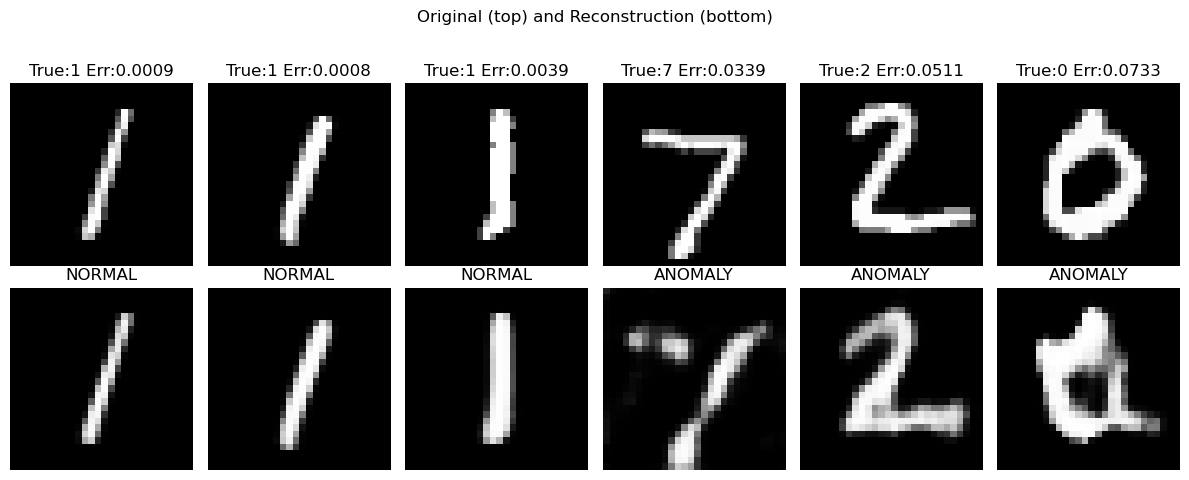

In [7]:
# Cell 7: Visualization - sample original vs reconstruction
import matplotlib.pyplot as plt

# Separate normal vs anomaly in test (based on label)
is_normal_test = (y_test == normal_class)

# Show some examples: original (top) and reconstruction (bottom)
n = 6
plt.figure(figsize=(12, 5))
example_idx = np.concatenate([
    np.where(is_normal_test)[0][:n//2],           # a few normal examples
    np.where(~is_normal_test)[0][:n - n//2]       # a few anomalies
])

for i, idx in enumerate(example_idx):
    # original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[idx].reshape(28,28), cmap='gray', vmin=0, vmax=1)
    plt.title(f"True:{y_test[idx]} Err:{test_mse[idx]:.4f}")
    plt.axis('off')
    # reconstruction
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(recon_test[idx].reshape(28,28), cmap='gray', vmin=0, vmax=1)
    flag = "ANOMALY" if anomaly_flags[idx] else "NORMAL"
    plt.title(flag)
    plt.axis('off')

plt.suptitle("Original (top) and Reconstruction (bottom)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
